In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from workalendar.asia import SouthKorea 

# statsmodel 확인
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from torch.utils.data import DataLoader, TensorDataset
import statsmodels.api as sm

# 오류 무시하는 방법
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/mnt/nvme/tilting/power_demand_final.csv")
df["일시"] = pd.to_datetime(df["일시"])
df["holiday_name"].fillna("non-event", inplace=True)

In [3]:
train_data = df[df["일시"] < "2024-08-31"]
train_data.set_index("일시", inplace=True)

val_data = df[(df["일시"] >= "2024-08-31") & (df["일시"] <= "2024-09-30 23:00:00")]
val_data.set_index("일시", inplace=True)

test_data = df[df["일시"] > "2024-10-01"]
test_data.set_index("일시", inplace=True)

# val-test 결합하여 처리한다.
val_test_data = pd.concat([val_data, test_data])

# 이후 holiday_name 은 제거
train_data.drop(columns=["holiday_name"], inplace=True)
val_test_data.drop(columns=["holiday_name"], inplace=True)

# Trend 확인

In [4]:
df.set_index("일시", inplace=True)

# 1️⃣ 추세 모델은 train 구간에서만 학습
t_train = np.arange(len(train_data))
X_train = sm.add_constant(t_train)
trend_model = sm.OLS(np.log(train_data["power demand(MW)"]), X_train).fit()

# 2️⃣ 전체 df 길이에 맞춰 추세 예측
t_all = np.arange(len(df))
X_all = sm.add_constant(t_all)
trend_hat_log = trend_model.predict(X_all)
trend_hat_exp = np.exp(trend_hat_log)

# 3️⃣ 전체 df에 임시로 붙이기
df["trend"] = trend_hat_exp
df["detrend"] = df["power demand(MW)"] - df["trend"]

# 4️⃣ 다시 split 복원
train_data["trend"] = df.loc[train_data.index, "trend"]
train_data["detrend"] = df.loc[train_data.index, "detrend"]

val_test_data["trend"] = df.loc[val_test_data.index, "trend"]
val_test_data["detrend"] = df.loc[val_test_data.index, "detrend"]

## 푸리에

Best (Kd, Kw, Ky): (3, 8, 4), Validation MSE: 50781875.9751


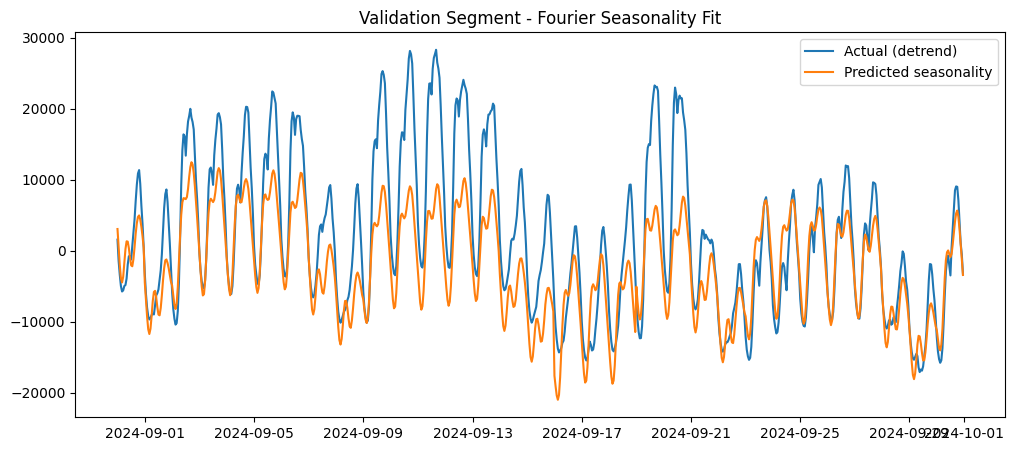

✅ Fourier-based seasonality successfully fitted and added as df['seasonality']


In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.preprocessing import StandardScaler

# ============================================================================
# 0️⃣ 데이터 전제
# ============================================================================
# df: 전체 시계열 데이터프레임 (1시간 단위)
#   columns 예시: ['일시', 'power demand(MW)', 'hm', 'ta', ...]
# train_data, val_data, test_data: 시계열 분할된 DataFrame
#   (index가 '일시'인 상태라고 가정)
# detrend 컬럼이 df에 포함되어 있어야 함 (이미 추세 제거된 시계열)

# 예시)
# train_end = len(train_data)
# val_end = train_end + len(val_data)

# ============================================================================
# 1️⃣ Fourier term 생성 함수
# ============================================================================
def generate_fourier_terms(timesteps, period, K):
    """
    주기(period)와 조화항 수(K)를 받아 Fourier sine/cosine term 생성
    """
    terms = []
    for k in range(1, K + 1):
        terms.append(np.sin(2 * np.pi * k * timesteps / period))
        terms.append(np.cos(2 * np.pi * k * timesteps / period))
    return np.stack(terms, axis=1)


# ============================================================================
# 2️⃣ 학습 / 검증 분할 기준 설정
# ============================================================================
y_all = df["detrend"].values
t_all = np.arange(len(y_all))

train_end = len(train_data)
val_end   = train_end + len(val_data)

# ============================================================================
# 3️⃣ Fourier 차수 탐색 범위 설정
# ============================================================================
daily_K_vals  = [1, 2, 3]             # 일주기 성분
weekly_K_vals = [1, 2, 3, 4, 5, 6, 7, 8]  # 주간 주기
yearly_K_vals = [1, 2, 3, 4]          # 연간 주기

best_mse = float("inf")
best_model, best_X_all, best_K_combo = None, None, None

# ============================================================================
# 4️⃣ (Optional) 외생변수 설정 (없으면 주석 처리 가능)
# ============================================================================
use_exog = True
if use_exog:
    exog_features = ["hm", "ta", "weekday", "weekend", 
                     "spring", "summer", "autoum", "winter", "is_holiday_dummies"]
    scaler = StandardScaler()
    X_exog = scaler.fit_transform(df[exog_features].values)
else:
    X_exog = None

# ============================================================================
# 5️⃣ Fourier + 외생변수 결합 모델 학습
# ============================================================================
for Kd, Kw, Ky in product(daily_K_vals, weekly_K_vals, yearly_K_vals):
    # Fourier terms 생성
    X_fourier = np.hstack([
        generate_fourier_terms(t_all, 24, Kd),          # 1일
        generate_fourier_terms(t_all, 24*7, Kw),        # 1주
        generate_fourier_terms(t_all, 24*365.25, Ky)    # 1년
    ])
    
    # 외생변수 추가 (옵션)
    if X_exog is not None:
        X_all = np.hstack([X_fourier, X_exog])
    else:
        X_all = X_fourier

    # train / val 분리
    X_train = X_all[:train_end]
    X_val   = X_all[train_end:val_end]
    y_train = y_all[:train_end]
    y_val   = y_all[train_end:val_end]

    # 학습
    model = LinearRegression().fit(X_train, y_train)
    val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, val_pred)

    # 최적 모델 갱신
    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_X_all = X_all
        best_K_combo = (Kd, Kw, Ky)

# ============================================================================
# 6️⃣ 최적 Fourier 조합으로 전체 계절성 추정
# ============================================================================
print(f"Best (Kd, Kw, Ky): {best_K_combo}, Validation MSE: {best_mse:.4f}")

seasonality_pred = best_model.predict(best_X_all)
df["seasonality"] = seasonality_pred

# ============================================================================
# 7️⃣ (Optional) 검증 구간 시각화
# ============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index[val_end - len(val_data):val_end], y_all[train_end:val_end], label="Actual (detrend)")
plt.plot(df.index[val_end - len(val_data):val_end], seasonality_pred[train_end:val_end], label="Predicted seasonality")
plt.legend()
plt.title("Validation Segment - Fourier Seasonality Fit")
plt.show()

print("✅ Fourier-based seasonality successfully fitted and added as df['seasonality']")


✅ Fourier decomposition successful.
  daily_terms.shape  = (51144, 6)
  weekly_terms.shape = (51144, 16)
  yearly_terms.shape = (51144, 8)
  coef length = 39
  Fourier-only coef length = 30
  (Kd, Kw, Ky) = (3, 8, 4)


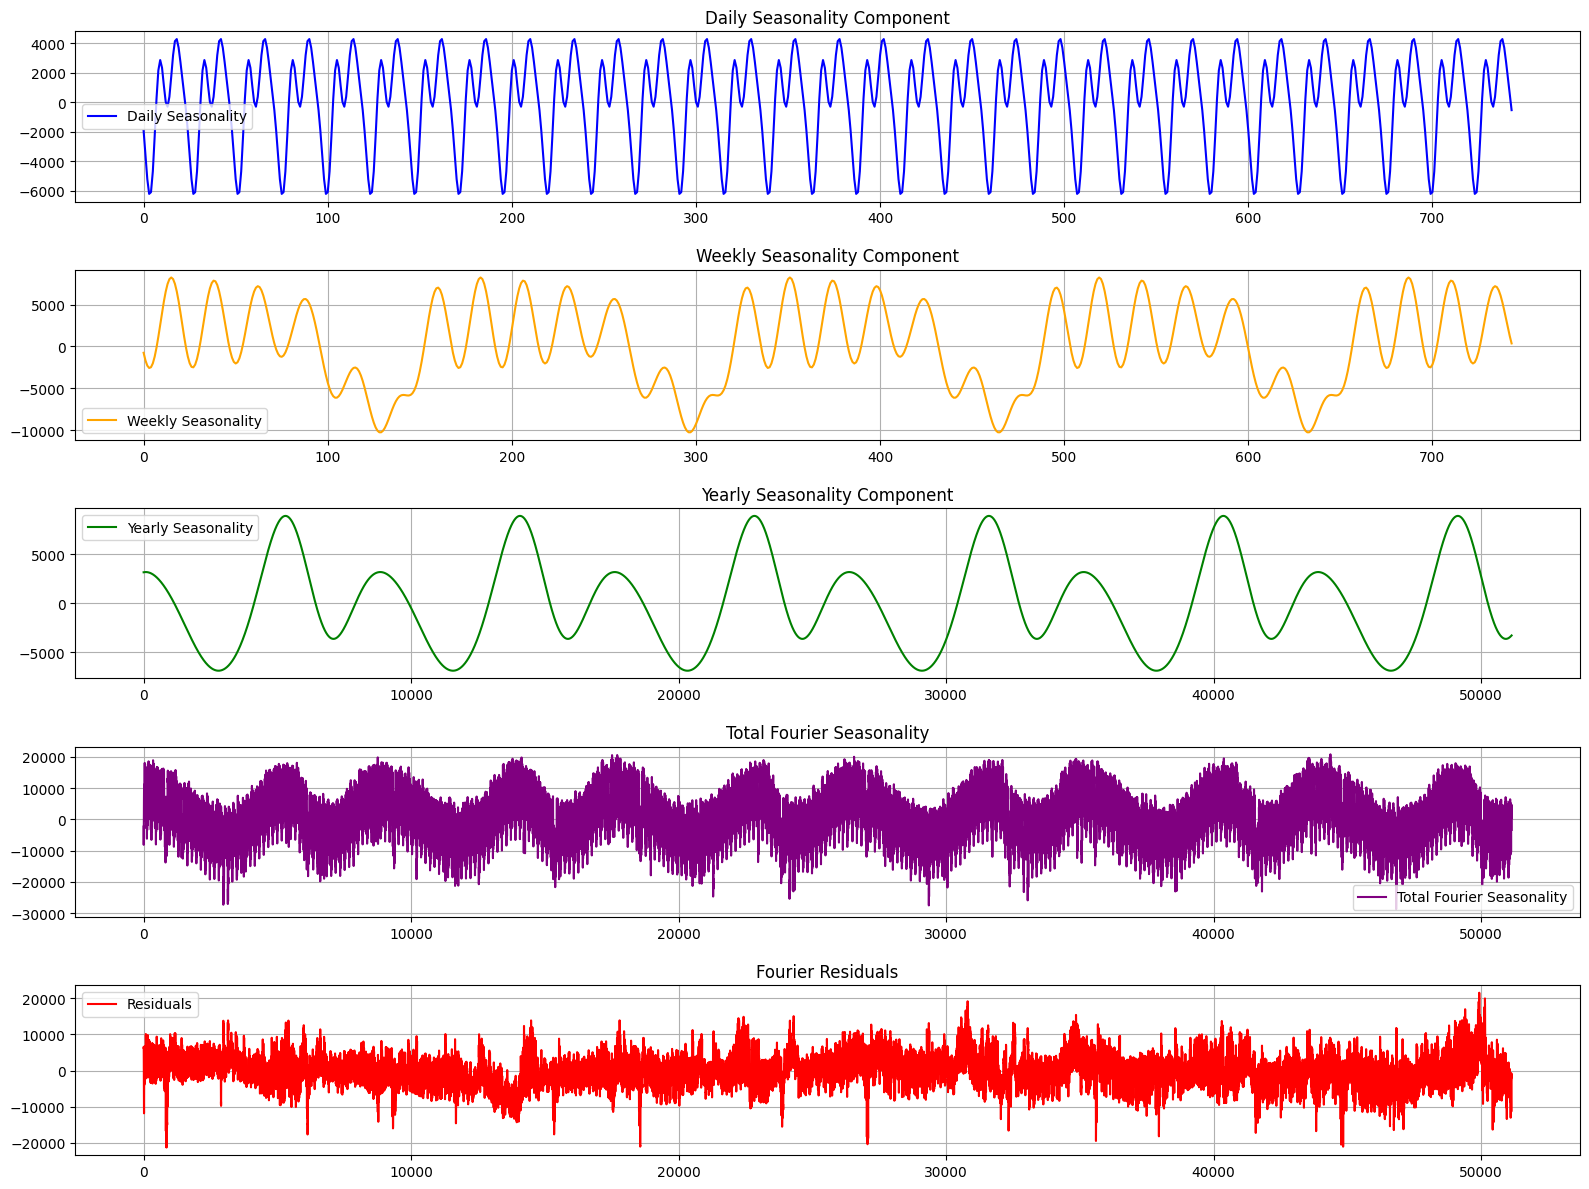

In [6]:
# ============================================================================
# FOURIER SEASONALITY DECOMPOSITION (SAFE VERSION)
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 시간 인덱스 보정 ---
if "t" not in df.columns:
    df["t"] = np.arange(len(df))

df_result = df.copy()

# --- 2. 최적 K 조합 추출 ---
Kd, Kw, Ky = best_K_combo

# --- 3. Fourier term 재생성 ---
daily_terms  = generate_fourier_terms(t_all, 24, Kd)
weekly_terms = generate_fourier_terms(t_all, 24*7, Kw)
yearly_terms = generate_fourier_terms(t_all, 24*365.25, Ky)

# --- 4. 계수 추출 및 분리 (외생변수 포함 대비) ---
coef = best_model.coef_

# Fourier term 총 개수
n_Fourier = 2 * (Kd + Kw + Ky)

# Fourier term 계수만 분리
coef_fourier = coef[:n_Fourier]

# 각 성분별 계수 분리
coef_daily  = coef_fourier[:2*Kd]
coef_weekly = coef_fourier[2*Kd:2*Kd + 2*Kw]
coef_yearly = coef_fourier[2*Kd + 2*Kw:2*Kd + 2*Kw + 2*Ky]

# --- 5. 성분별 예측 ---
daily_pred_log  = daily_terms  @ coef_daily
weekly_pred_log = weekly_terms @ coef_weekly
yearly_pred_log = yearly_terms @ coef_yearly

# --- 6. 전체 seasonality 및 잔차 계산 ---
seasonality_pred_log = best_model.predict(best_X_all)
residuals_log = y_all - seasonality_pred_log

df_result["Fourier_Seasonality"] = seasonality_pred_log
df_result["Fourier_Residual"]    = residuals_log

# --- 7. 차원 확인 (디버깅용) ---
print("✅ Fourier decomposition successful.")
print(f"  daily_terms.shape  = {daily_terms.shape}")
print(f"  weekly_terms.shape = {weekly_terms.shape}")
print(f"  yearly_terms.shape = {yearly_terms.shape}")
print(f"  coef length = {len(coef)}")
print(f"  Fourier-only coef length = {n_Fourier}")
print(f"  (Kd, Kw, Ky) = ({Kd}, {Kw}, {Ky})")

# --- 8. 시각화 ---
plt.figure(figsize=(16, 12))

# 1. 일간 성분
plt.subplot(5, 1, 1)
plt.plot(df_result["t"][:24*31], daily_pred_log[:24*31], label="Daily Seasonality", color='blue')
plt.title("Daily Seasonality Component")
plt.grid(True)
plt.legend()

# 2. 주간 성분
plt.subplot(5, 1, 2)
plt.plot(df_result["t"][:24*31], weekly_pred_log[:24*31], label="Weekly Seasonality", color='orange')
plt.title("Weekly Seasonality Component")
plt.grid(True)
plt.legend()

# 3. 연간 성분
plt.subplot(5, 1, 3)
plt.plot(df_result["t"], yearly_pred_log, label="Yearly Seasonality", color='green')
plt.title("Yearly Seasonality Component")
plt.grid(True)
plt.legend()

# 4. 전체 seasonality
plt.subplot(5, 1, 4)
plt.plot(df_result["t"], df_result["Fourier_Seasonality"], label="Total Fourier Seasonality", color='purple')
plt.title("Total Fourier Seasonality")
plt.grid(True)
plt.legend()

# 5. 잔차
plt.subplot(5, 1, 5)
plt.plot(df_result["t"], df_result["Fourier_Residual"], label="Residuals", color='red')
plt.title("Fourier Residuals")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


Component  Harmonic k         aₖ         bₖ  Amplitude  Phase (rad)  Phase (deg)
    Daily           1 -2839.3436 -2107.0542  3535.7530      -2.5032      -143.42
    Daily           2 -2244.8785  -968.5629  2444.9118      -2.7343      -156.66
    Daily           3   458.1881  1125.9353  1215.5931       1.1843        67.86
   Weekly           1  4687.7927   167.8382  4690.7963       0.0358         2.05
   Weekly           2     3.6830  2760.7008  2760.7033       1.5695        89.92
   Weekly           3  -952.3676   374.6275  1023.4011       2.7668       158.53
   Weekly           4  -714.4267   157.8782   731.6632       2.9241       167.54
   Weekly           5  -863.2124 -1038.1304  1350.1298      -2.2645      -129.74
   Weekly           6  1343.2169  -815.6749  1571.4825      -0.5457       -31.27
   Weekly           7 -2839.3436 -2107.0542  3535.7530      -2.5032      -143.42
   Weekly           8 -1319.1190  -264.0178  1345.2807      -2.9441      -168.68
   Yearly           1 -3312.

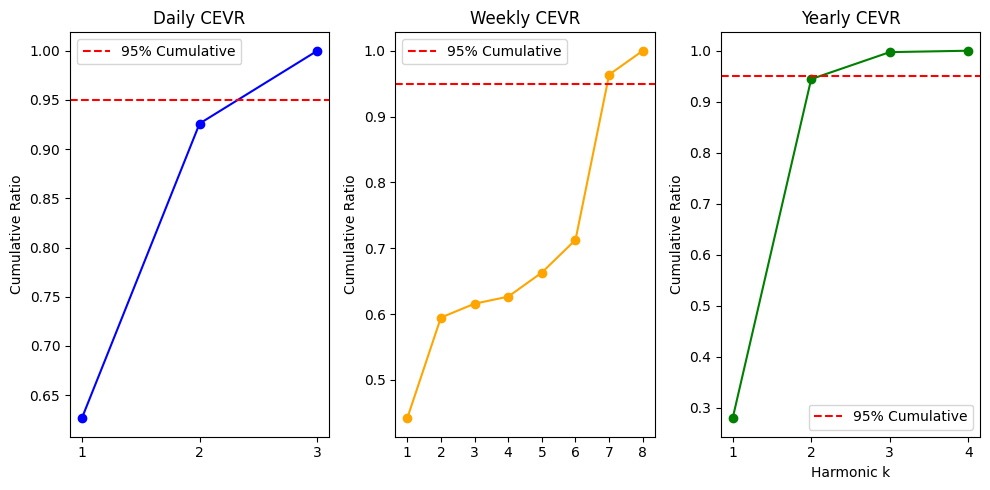

In [7]:
def extract_amplitude_phase(coef_block, K, label):
    results = []
    for k in range(K):
        a_k = coef_block[2 * k]
        b_k = coef_block[2 * k + 1]
        amplitude = np.sqrt(a_k**2 + b_k**2)
        phase_rad = np.arctan2(b_k, a_k)
        phase_deg = np.degrees(phase_rad)
        results.append({
            "Component": label,
            "Harmonic k": k + 1,
            "aₖ": round(a_k, 4),
            "bₖ": round(b_k, 4),
            "Amplitude": round(amplitude, 4),
            "Phase (rad)": round(phase_rad, 4),
            "Phase (deg)": round(phase_deg, 2)
        })
    return results

# 최적 K
Kd, Kw, Ky = best_K_combo
coef = best_model.coef_

# 계수 분할
daily_coef   = coef[:2 * Kd]
weekly_coef  = coef[2 * Kd : 2 * Kd + 2 * Kw]
yearly_coef  = coef[2 * Kd + 2 * Kw:]

# 해석 실행
daily_info  = extract_amplitude_phase(daily_coef,  Kd, "Daily")
weekly_info = extract_amplitude_phase(weekly_coef, Kw, "Weekly")
yearly_info = extract_amplitude_phase(yearly_coef, Ky, "Yearly")

# 결과 통합
seasonality_df = pd.DataFrame(daily_info + weekly_info + yearly_info)

# 시각 또는 테이블 출력

print(seasonality_df.to_string(index=False))

# 누적 설명력 계산

def confidential_test(data, component):
    # 필터링 
    data = data[data["Component"]==component]
    energy = data["aₖ"].values**2 + data["bₖ"].values**2

    total_energy = np.sum(energy)
    cumulative_ratio = np.cumsum(energy) / total_energy

    print("누적 설명력:", np.round(cumulative_ratio, 4))

    return np.round(cumulative_ratio, 4)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

# 각각의 누적 설명력 시리즈 생성
daily = confidential_test(seasonality_df, "Daily")
weekly = confidential_test(seasonality_df, "Weekly")
yearly = confidential_test(seasonality_df, "Yearly")

# Subplot 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=False)

# 공통: x축 눈금을 정수로 고정
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 1. Daily
axes[0].plot(np.arange(1, len(daily)+1), daily, marker='o', color='blue')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[0].set_title("Daily CEVR")
axes[0].set_ylabel("Cumulative Ratio")
axes[0].legend()

# 2. Weekly
axes[1].plot(np.arange(1, len(weekly)+1), weekly, marker='o', color='orange')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[1].set_title("Weekly CEVR")
axes[1].set_ylabel("Cumulative Ratio")
axes[1].legend()

# 3. Yearly
axes[2].plot(np.arange(1, len(yearly)+1), yearly, marker='o', color='green')
axes[2].axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative')
axes[2].set_title("Yearly CEVR")
axes[2].set_xlabel("Harmonic k")
axes[2].set_ylabel("Cumulative Ratio")
axes[2].legend()

plt.tight_layout()
plt.show()


## AR 모형 생성

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(test["Fourier_Residual"].values, lags=48)  # 48시간(2일)까지 자기상관 보기
plt.title("Autocorrelation (ACF)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(test["Fourier_Residual"].values, lags=48)
plt.title("Partial Autocorrelation (PACF)")
plt.show()

# 해당 결과 확인결과 AR 모형에서 자기상관성이 있음을 확인함. lags=24 를 기반으로 처리하는게 맞는듯


NameError: name 'test' is not defined

<Figure size 1000x400 with 0 Axes>

In [9]:
val

NameError: name 'val' is not defined

In [65]:
val_test_merge = pd.concat([val, test])

In [66]:
val_test_merge

,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies,trend,detrend,seasonality,t,Fourier_Seasonality,Fourier_Residual
일시,,,,,,,,,,,,,,,,,
2024-08-31 00:00:00,83.328131,24.295071,66479.0,non-event,0,1,0,1,0,0,0,64915.479331,1563.520669,798.249978,49656,798.249978,765.270691
2024-08-31 01:00:00,83.972046,23.718131,63458.0,non-event,0,1,0,1,0,0,0,64915.552106,-1457.552106,-1954.685302,49657,-1954.685302,497.133196
2024-08-31 02:00:00,85.067284,23.206675,61523.0,non-event,0,1,0,1,0,0,0,64915.624882,-3392.624882,-4582.549739,49658,-4582.549739,1189.924857
2024-08-31 03:00:00,86.666578,22.731367,59935.0,non-event,0,1,0,1,0,0,0,64915.697658,-4980.697658,-6487.508285,49659,-6487.508285,1506.810628
2024-08-31 04:00:00,88.062169,22.337346,59172.0,non-event,0,1,0,1,0,0,0,64915.770433,-5743.770433,-7141.622085,49660,-7141.622085,1397.851651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,75.547619,15.667637,67551.0,non-event,1,0,0,0,1,0,0,65023.495091,2527.504909,4766.217907,51139,4766.217907,-2238.712997
2024-10-31 20:00:00,79.587125,14.787954,65341.0,non-event,1,0,0,0,1,0,0,65023.567987,317.432013,3110.168587,51140,3110.168587,-2792.736574
2024-10-31 21:00:00,82.265079,14.053263,63341.0,non-event,1,0,0,0,1,0,0,65023.640884,-1682.640884,1307.044315,51141,1307.044315,-2989.685199


In [61]:
from statsmodels.tsa.ar_model import AutoReg


model = AutoReg(train["Fourier_Residual"], lags=24, old_names=False)
result = model.fit()
print(result.summary())


                            AutoReg Model Results                             
Dep. Variable:       Fourier_Residual   No. Observations:                49656
Model:                    AutoReg(24)   Log Likelihood             -412338.575
Method:               Conditional MLE   S.D. of innovations            981.399
Date:                Fri, 07 Nov 2025   AIC                         824729.149
Time:                        01:27:00   BIC                         824958.272
Sample:                    01-02-2019   HQIC                        824800.945
                         - 08-30-2024                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7407      4.405      0.168      0.866      -7.893       9.375
Fourier_Residual.L1      1.4587      0.004    333.371      0.000       1.450       1.467
Fourier_Resi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse, meanabs
import warnings
warnings.filterwarnings('ignore')

# ============= AIC 기반 최적 p 선정 (Train 데이터로만!) =============
def select_optimal_lags(train_data, max_lags=20):
    """
    Train 데이터로 AIC 기준 최적 lags 선정 (한 번만!)
    
    Parameters:
    - train_data: Train 시계열 데이터
    - max_lags: 탐색할 최대 lag 수
    
    Returns:
    - best_lag: 최적 lag 값
    - aic_results: lag별 AIC 결과 DataFrame
    """
    max_lags = min(max_lags, len(train_data) // 3)
    results = []
    
    print("=" * 60)
    print("🔍 Train 데이터로 최적 lags 선정 중 (AIC 기준)...")
    print(f"Train 데이터 크기: {len(train_data)}")
    print(f"탐색 범위: lags = 1 ~ {max_lags}")
    print("=" * 60)
    
    for lag in range(1, max_lags + 1):
        try:
            model = AutoReg(train_data, lags=lag, old_names=False)
            result = model.fit()
            
            results.append({
                'lags': lag,
                'AIC': result.aic,
                'BIC': result.bic,
                'HQIC': result.hqic
            })
            
            print(f"lags = {lag:2d} → AIC = {result.aic:10.2f}, BIC = {result.bic:10.2f}")
        except Exception as e:
            print(f"⚠️  lags = {lag} 실패: {e}")
            continue
    
    aic_df = pd.DataFrame(results)
    
    if len(aic_df) == 0:
        raise ValueError("모든 lag에서 학습 실패")
    
    best_lag = int(aic_df.loc[aic_df['AIC'].idxmin(), 'lags'])
    best_aic = aic_df['AIC'].min()
    
    print("=" * 60)
    print(f"✅ 최적 lags 선정 완료: lags = {best_lag} (AIC = {best_aic:.2f})")
    print("=" * 60)
    
    return best_lag, aic_df


# ============= 롤링 윈도우 예측 (Test 구간만!) =============

def rolling_window_forecast(data, lags, test_size):
    """
    롤링 윈도우 방식으로 예측 (Test 구간만!)
    
    각 Test 시점마다:
    1. 현재까지의 모든 데이터로 AR(lags) 재학습
    2. 1-step ahead 예측
    3. 실제값과 비교
    
    Parameters:
    - data: 전체 시계열 데이터 (pandas Series 또는 numpy array)
    - lags: AR 차수 (Train에서 선정된 값, 고정!)
    - test_size: Test 데이터 크기
    
    Returns:
    - predictions: 예측값 배열
    - actuals: 실제값 배열
    """
    if isinstance(data, pd.Series):
        data = data.values
    
    train_size = len(data) - test_size
    predictions = []
    actuals = []
    
    print("\n" + "=" * 60)
    print("🔄 롤링 윈도우 예측 시작 (Test 구간)")
    print(f"Train 크기: {train_size}, Test 크기: {test_size}")
    print(f"선정된 lags = {lags} (고정, 매 시점마다 재학습)")
    print("=" * 60)
    
    for i in range(test_size):
        # 현재 시점까지의 데이터 (Train + Test의 일부)
        current_data = data[:train_size + i]
        actual = data[train_size + i]
        
        try:
            # AR(lags) 모델 재학습
            model = AutoReg(current_data, lags=lags, old_names=False)
            result = model.fit()
            
            # 1-step ahead 예측
            pred = result.predict(start=len(current_data), end=len(current_data))[0]
            
        except Exception as e:
            # 예외 발생 시 마지막 값 사용
            pred = current_data[-1]
            print(f"⚠️  Step {i+1}/{test_size} 예측 실패: {e}")
        
        predictions.append(pred)
        actuals.append(actual)
        
        # 진행 상황 표시
        if (i + 1) % max(1, test_size // 10) == 0:
            print(f"Progress: {i+1}/{test_size} steps completed ({(i+1)/test_size*100:.1f}%)")
    
    print("✅ 롤링 윈도우 예측 완료!")
    print("=" * 60)
    
    return np.array(predictions), np.array(actuals)


# ============= 성능 평가 =============

def evaluate_predictions(actuals, predictions):
    """
    예측 성능 평가
    
    Returns:
    - metrics: 성능 지표 딕셔너리
    """
    mse = np.mean((actuals - predictions) ** 2)
    rmse_val = np.sqrt(mse)
    mae = np.mean(np.abs(actuals - predictions))
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    # 잔차 분석
    residuals = actuals - predictions
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse_val,
        'MAE': mae,
        'MAPE': mape,
        'Residual_Mean': residual_mean,
        'Residual_Std': residual_std
    }
    
    print("\n" + "=" * 60)
    print("📊 모델 성능 지표 (Test 구간)")
    print("=" * 60)
    print(f"{'Metric':<20} {'Value':>15}")
    print("-" * 60)
    for metric, value in metrics.items():
        if 'MAPE' in metric:
            print(f"{metric:<20} {value:>14.2f}%")
        else:
            print(f"{metric:<20} {value:>15.4f}")
    print("=" * 60)
    
    return metrics


# ============= 시각화 =============

def plot_results(data, predictions, train_size, lags, aic_df=None):
    """결과 시각화"""
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. AIC/BIC 비교 그래프
    if aic_df is not None:
        ax1 = plt.subplot(4, 1, 1)
        ax1.plot(aic_df['lags'], aic_df['AIC'], 'o-', label='AIC', linewidth=2)
        ax1.plot(aic_df['lags'], aic_df['BIC'], 's-', label='BIC', linewidth=2)
        ax1.axvline(lags, color='red', linestyle='--', linewidth=2, 
                   label=f'Selected lags={lags}')
        ax1.set_xlabel('Lags', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Information Criterion', fontsize=12, fontweight='bold')
        ax1.set_title('모델 선택 기준 (Train 데이터 기반 - 낮을수록 좋음)', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
    
    # 2. 전체 시계열 + 예측
    ax2 = plt.subplot(4, 1, 2)
    
    time_index = range(len(data))
    ax2.plot(time_index, data, label='실제 값', color='black', linewidth=2, alpha=0.7)
    
    # Train/Test 구분선
    ax2.axvline(train_size, color='gray', linestyle='--', linewidth=2, 
               label='Train/Test 구분', alpha=0.7)
    ax2.axvspan(0, train_size, alpha=0.1, color='blue', label='Train 구간')
    ax2.axvspan(train_size, len(data), alpha=0.1, color='orange', label='Test 구간')
    
    # 예측 값
    test_indices = range(train_size, len(data))
    ax2.plot(test_indices, predictions, label=f'AR({lags}) 롤링 예측', 
            color='red', linestyle='--', linewidth=2, marker='o')
    
    ax2.set_xlabel('Time Index', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax2.set_title(f'시계열 예측 결과 (롤링 윈도우, AR({lags}))', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    
    # 3. Test 구간 확대
    ax3 = plt.subplot(4, 1, 3)
    
    test_actuals = data[train_size:]
    test_time = range(len(test_actuals))
    
    ax3.plot(test_time, test_actuals, 'o-', label='실제 값', 
            color='black', linewidth=2, markersize=6)
    ax3.plot(test_time, predictions, 's--', label=f'AR({lags}) 예측', 
            color='red', linewidth=2, markersize=6)
    
    ax3.set_xlabel('Test Time Index', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax3.set_title('Test 구간 상세 비교', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # 4. 잔차 플롯
    ax4 = plt.subplot(4, 1, 4)
    
    residuals = test_actuals - predictions
    ax4.plot(test_time, residuals, 'o-', color='purple', linewidth=1.5, markersize=5)
    ax4.axhline(0, color='black', linestyle='-', linewidth=1)
    ax4.axhline(np.mean(residuals), color='red', linestyle='--', 
               linewidth=2, label=f'Mean = {np.mean(residuals):.4f}')
    ax4.axhline(np.mean(residuals) + 2*np.std(residuals), color='orange', 
               linestyle=':', linewidth=1.5, label='±2σ')
    ax4.axhline(np.mean(residuals) - 2*np.std(residuals), color='orange', 
               linestyle=':', linewidth=1.5)
    
    ax4.set_xlabel('Test Time Index', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Residual', fontsize=12, fontweight='bold')
    ax4.set_title('잔차 분석 (Actual - Predicted)', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# ============= Train 구간 Fitted Values 계산 =============

def get_train_fitted(train_data, lags):
    """
    Train 데이터의 fitted values와 잔차 계산
    
    Returns:
    - fitted: fitted values
    - residuals: 잔차 (actual - fitted)
    """
    model = AutoReg(train_data, lags=lags, old_names=False)
    result = model.fit()
    
    # Fitted values (in-sample 예측)
    fitted = result.fittedvalues
    
    # 잔차
    residuals = train_data[lags:] - fitted
    
    print("\n" + "=" * 60)
    print("📈 Train 구간 Fitted Values")
    print("=" * 60)
    print(f"Train 크기: {len(train_data)}")
    print(f"Fitted values 크기: {len(fitted)} (처음 {lags}개는 NA)")
    print(f"잔차 평균: {np.mean(residuals):.4f}")
    print(f"잔차 표준편차: {np.std(residuals):.4f}")
    print("=" * 60)
    
    return fitted, residuals, result


# ============= 메인 실행 예제 =============

if __name__ == "__main__":
    
    print("\n" + "="*60)
    print("  AR 모델 시계열 예측 (statsmodels AutoReg)")
    print("  - Train: 최적 lags 선정 (한 번만)")
    print("  - Test: 롤링 윈도우 예측 (매 시점 재학습)")
    print("="*60)

    train_data = train["Fourier_Residual"]
    test_data = val_test_merge["Fourier_Residual"]
    
    # 1. Train으로 lags 선정
    best_lags, aic_results = select_optimal_lags(train_data, max_lags=20)
    
    # 2. Train 구간 fitted values & 잔차
    train_fitted, train_residuals, model_result = get_train_fitted(train_data, best_lags)
    
    # 3. 전체 데이터 결합
    full_data = pd.concat([train_data, test_data])
    
    # 4. Test 구간 롤링 윈도우 예측
    predictions, actuals = rolling_window_forecast(
        full_data,
        best_lags, 
        test_size=len(test_data)
    )
    
    # 5. Test 성능 평가
    metrics = evaluate_predictions(actuals, predictions)
    
    print("=======  종료 =======")


  AR 모델 시계열 예측 (statsmodels AutoReg)
  - Train: 최적 lags 선정 (한 번만)
  - Test: 롤링 윈도우 예측 (매 시점 재학습)
🔍 Train 데이터로 최적 lags 선정 중 (AIC 기준)...
Train 데이터 크기: 49656
탐색 범위: lags = 1 ~ 20
lags =  1 → AIC =  860973.27, BIC =  860999.71
lags =  2 → AIC =  851564.37, BIC =  851599.62
lags =  3 → AIC =  851539.21, BIC =  851583.27
lags =  4 → AIC =  851511.54, BIC =  851564.41
lags =  5 → AIC =  850290.31, BIC =  850352.00
lags =  6 → AIC =  847450.27, BIC =  847520.77
lags =  7 → AIC =  847328.02, BIC =  847407.33
lags =  8 → AIC =  847259.98, BIC =  847348.10
lags =  9 → AIC =  846202.50, BIC =  846299.44
lags = 10 → AIC =  844761.20, BIC =  844866.96
lags = 11 → AIC =  842419.94, BIC =  842534.50
lags = 12 → AIC =  840057.46, BIC =  840180.84
lags = 13 → AIC =  839838.84, BIC =  839971.03
lags = 14 → AIC =  837255.08, BIC =  837396.09
lags = 15 → AIC =  837200.72, BIC =  837350.54
lags = 16 → AIC =  835998.92, BIC =  836157.55
lags = 17 → AIC =  835837.68, BIC =  836005.12
lags = 18 → AIC =  83415

(array([  9.,  27., 119., 430., 470., 279., 105.,  14.,  27.,   7.]),
 array([-3407.49882069, -2643.2121917 , -1878.9255627 , -1114.63893371,
         -350.35230471,   413.93432428,  1178.22095328,  1942.50758227,
         2706.79421127,  3471.08084026,  4235.36746926]),
 <BarContainer object of 10 artists>)

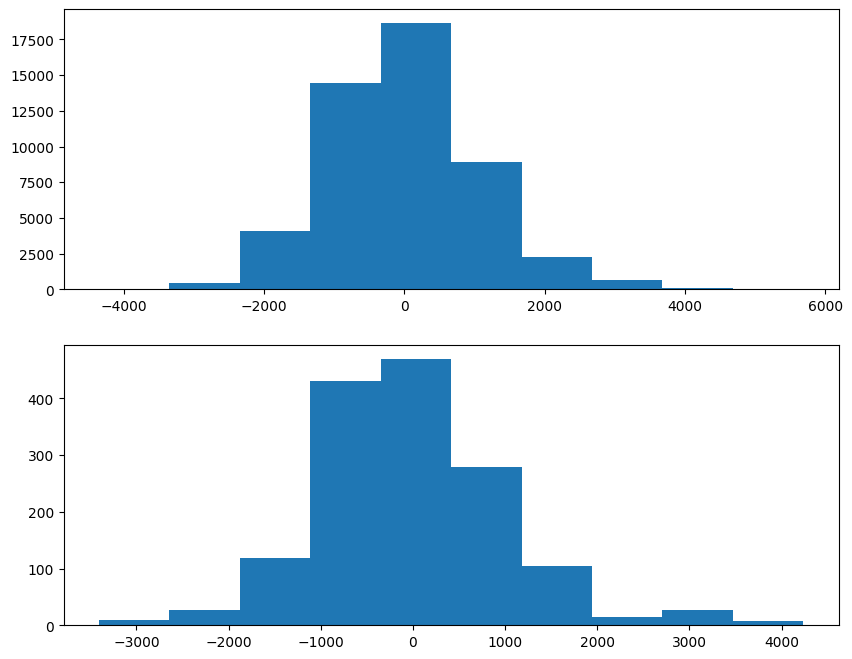

In [ ]:
# AR 모델 관련 코드 - 제거됨
# (train_ar_resid, test_ar_resid 변수는 더 이상 사용되지 않음)

In [ ]:
# AR 모델 관련 코드 - 제거됨


일시
2024-08-31 00:00:00    -817.023297
2024-08-31 01:00:00     390.838430
2024-08-31 02:00:00    1564.300626
2024-08-31 03:00:00    -248.885885
2024-08-31 04:00:00    -842.738387
                          ...     
2024-10-31 19:00:00    -640.885769
2024-10-31 20:00:00    -624.607861
2024-10-31 21:00:00      40.459364
2024-10-31 22:00:00    -218.581394
2024-10-31 23:00:00   -1048.338896
Name: AR_residual, Length: 1487, dtype: float64

In [ ]:
# AR 모델 관련 코드 - 제거됨
# (final_train, final_val_test 변수는 더 이상 사용되지 않음)

                            hm         ta  power demand(MW) holiday_name  \
일시                                                                         
2024-08-31 00:00:00  83.328131  24.295071           66479.0    non-event   
2024-08-31 01:00:00  83.972046  23.718131           63458.0    non-event   
2024-08-31 02:00:00  85.067284  23.206675           61523.0    non-event   
2024-08-31 03:00:00  86.666578  22.731367           59935.0    non-event   
2024-08-31 04:00:00  88.062169  22.337346           59172.0    non-event   
...                        ...        ...               ...          ...   
2024-10-31 19:00:00  75.547619  15.667637           67551.0    non-event   
2024-10-31 20:00:00  79.587125  14.787954           65341.0    non-event   
2024-10-31 21:00:00  82.265079  14.053263           63341.0    non-event   
2024-10-31 22:00:00  84.185538  13.475044           62031.0    non-event   
2024-10-31 23:00:00  85.071605  13.044683           59913.0    non-event   

           

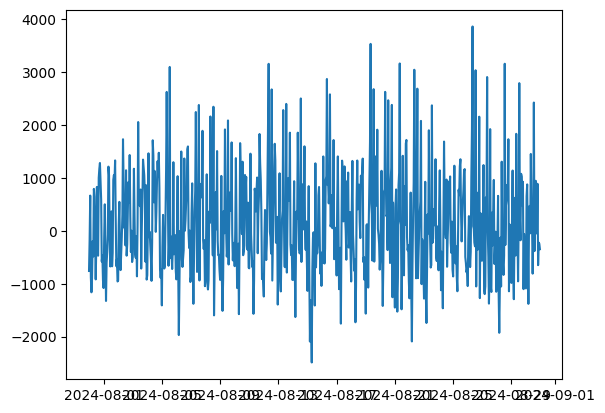

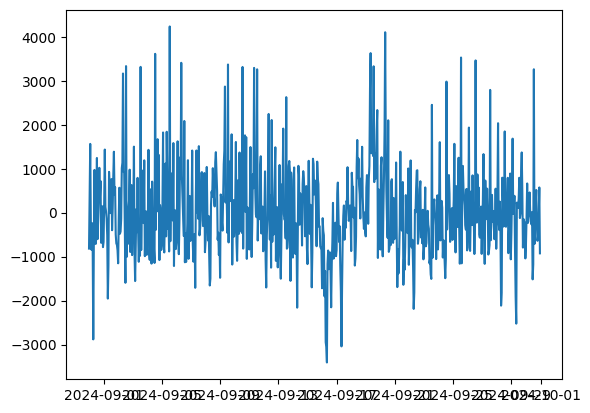

In [174]:
plt.plot(final_train[0][-len(final_val):])
plt.show()

plt.plot(final_val["AR_residual"])
plt.show()


## 딥러닝 확인
- Seq2Seq-LSTM 확인

## 딥러닝 전 전처리

In [ ]:
## 재분할 실시
### 제외시켜야 하는 변수 - AR 을 추가했을때는 이 코드는 생략한다.
train = df_result[df_result.index < "2024-08-31"].drop([])
val = df_result[(df_result.index >= "2024-08-31") & (df_result.index <= "2024-09-30 23:00:00")]
test = df_result[df_result.index > "2024-10-01"]

In [190]:
# train_x, train_y, val_x, val_y, test_x, test_y 등을 생성
train_x = pd.DataFrame(final_train[0])
train_y = final_train[0]

val_x = pd.DataFrame(final_val["AR_residual"])
val_y = final_val["AR_residual"]

test_x = pd.DataFrame(final_test["AR_residual"])
test_y = final_test["AR_residual"]

## 딥러닝 확인
- Seq2Seq-LSTM 확인

In [191]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import ParameterSampler
import time
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# MULTIVARIATE SEQ2SEQ LSTM MODEL
# ============================================================================

class MultivarSeq2SeqLSTM(nn.Module):
    """
    Multivariate Encoder-Decoder LSTM
    
    Input: Multiple features (temperature, humidity, etc.)
    Output: Single target (power demand)
    """
    
    def __init__(self, 
                 input_size,          # Number of input features
                 hidden_size=128, 
                 num_layers=2, 
                 dropout=0.2,
                 output_size=24,      # Forecast horizon
                 output_dim=1,        # Output dimension (1 for univariate)
                 bidirectional=False,
                 use_attention=False):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.output_dim = output_dim
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        
        num_directions = 2 if bidirectional else 1
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=output_dim,
            hidden_size=hidden_size * num_directions,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention
        if use_attention:
            self.attention = nn.Linear(hidden_size * num_directions * 2, 1)
        
        # Output layer
        self.fc = nn.Linear(hidden_size * num_directions, output_dim)
        
    def forward(self, x):
        """
        Args:
            x: (batch, window_size, input_size)
        Returns:
            predictions: (batch, output_size, output_dim)
        """
        batch_size = x.size(0)
        
        # Encoder
        encoder_outputs, (hidden, cell) = self.encoder(x)
        
        if self.bidirectional:
            hidden = self._cat_directions(hidden)
            cell = self._cat_directions(cell)
        
        # Decoder initial input
        decoder_input = torch.zeros(batch_size, 1, self.output_dim).to(x.device)
        
        outputs = []
        for t in range(self.output_size):
            if self.use_attention:
                decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
                
                decoder_repeated = decoder_output.repeat(1, encoder_outputs.size(1), 1)
                combined = torch.cat([decoder_repeated, encoder_outputs], dim=2)
                attention_scores = self.attention(combined).squeeze(2)
                attention_weights = torch.softmax(attention_scores, dim=1)
                
                context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
                combined_output = decoder_output + context
                prediction = self.fc(combined_output)
            else:
                decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
                prediction = self.fc(decoder_output)
            
            outputs.append(prediction)
            decoder_input = prediction
        
        return torch.cat(outputs, dim=1)
    
    def _cat_directions(self, h):
        return torch.cat([h[0::2], h[1::2]], dim=2)


# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_model(model, train_loader, val_loader, config, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=config['learning_rate'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )
    
    # Scheduler
    if config['scheduler'] == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif config['scheduler'] == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    elif config['scheduler'] == 'reduce':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    else:
        scheduler = None
    
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
    best_val_loss = float('inf')
    
    if verbose:
        print(f"\n{'Epoch':>5} {'Train Loss':>12} {'Val Loss':>12} {'Best Val':>12} {'Status':>10}", flush=True)
        print("-" * 65, flush=True)
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            loss.backward()
            
            if config['grad_clip'] > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update best
        status = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            status = "✓ Best"
        
        # Print epoch results
        if verbose:
            print(f"{epoch+1:5d} {train_loss:12.6f} {val_loss:12.6f} {best_val_loss:12.6f} {status:>10}", flush=True)
        
        # Scheduler
        if scheduler is not None:
            if config['scheduler'] == 'reduce':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch+1}", flush=True)
            break
    
    return best_val_loss


# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

class Seq2SeqTuner:
    """
    Hyperparameter tuning for Seq2Seq LSTM using existing train/val/test splits
    """
    
    def __init__(self, window_size=168, horizon=24, random_state=42):
        self.window_size = window_size
        self.horizon = horizon
        self.random_state = random_state
        
        # Hyperparameter search space (축소 버전)
        self.param_distributions = {
            # Model architecture
            'hidden_size': [64, 128, 256],              # 5 → 3개
            'num_layers': [2, 3],                        # 4 → 2개
            'dropout': [0.1, 0.2, 0.3],                 # 6 → 3개
            'bidirectional': [False, True],              # 2개
            'use_attention': [False, True],              # 2개
            
            # Training
            'batch_size': [32, 64],                      # 4 → 2개
            'learning_rate': [0.0005, 0.001, 0.005],    # 5 → 3개
            'optimizer': ['adamw'],                      # 3 → 1개 (AdamW 고정)
            'weight_decay': [0.0, 1e-4],                # 4 → 2개
            'grad_clip': [0.5, 1.0],                    # 4 → 2개
            
            # Regularization
            'scheduler': ['cosine', 'reduce'],           # 4 → 2개
            'early_stopping_patience': [10, 15],        # 3 → 2개
            
            # Data preprocessing
            'scaler': ['standard'],                      # 3 → 1개 (Standard 고정)
        }
        
        # 총 조합 수: 3×2×3×2×2 × 2×3×1×2×2 × 2×2 × 1 = 72 × 24 × 4 × 1 = 6,912개
        # Random Search로 n_iter개만 샘플링
        
        self.best_params = None
        self.best_score = float('inf')
        self.results = []
        
    def create_sliding_windows(self, X_df, y_series, stride=24):
        """
        Create sliding window dataset from DataFrame
        
        Args:
            X_df: DataFrame with features (already split)
            y_series: Series with target values
            stride: Window stride (기본 24 = non-overlapping, 1 = fully overlapping)
            
        Returns:
            X: (N, window_size, n_features)
            y: (N, horizon)
        """
        X_values = X_df.values
        y_values = y_series.values
        
        X_windows = []
        y_windows = []
        
        # Stride로 샘플링 (non-overlapping이면 stride=horizon)
        for i in range(0, len(X_values) - self.window_size - self.horizon + 1, stride):
            X_windows.append(X_values[i:i+self.window_size])
            y_windows.append(y_values[i+self.window_size:i+self.window_size+self.horizon])
        
        return np.array(X_windows), np.array(y_windows)
    
    def create_dataloaders(self, train_x, train_y, val_x, val_y, config, train_stride=24, val_stride=1):
        """
        Create DataLoaders from train/val data with sliding windows
        
        Args:
            train_stride: Training window stride (기본 24 = non-overlapping for speed)
            val_stride: Validation window stride (기본 1 = fully overlapping for accuracy)
        """
        # Create sliding windows
        print("Creating sliding windows...")
        X_train, y_train = self.create_sliding_windows(train_x, train_y, stride=train_stride)
        X_val, y_val = self.create_sliding_windows(val_x, val_y, stride=val_stride)
        
        print(f"  Train windows: {len(X_train)} (stride={train_stride})")
        print(f"  Val windows: {len(X_val)} (stride={val_stride})")
        print(f"  X shape: {X_train.shape}")
        print(f"  y shape: {y_train.shape}")
        
        n_features = X_train.shape[2]
        
        # Scaling
        if config['scaler'] == 'standard':
            scaler_x = StandardScaler()
            scaler_y = StandardScaler()
        elif config['scaler'] == 'minmax':
            scaler_x = MinMaxScaler()
            scaler_y = MinMaxScaler()
        else:
            scaler_x = RobustScaler()
            scaler_y = RobustScaler()
        
        # Reshape for scaling: (N*window, features) → scale → reshape back
        N_train, W, F = X_train.shape
        X_train_reshaped = X_train.reshape(-1, F)
        X_train_scaled = scaler_x.fit_transform(X_train_reshaped).reshape(N_train, W, F)
        
        N_val = X_val.shape[0]
        X_val_reshaped = X_val.reshape(-1, F)
        X_val_scaled = scaler_x.transform(X_val_reshaped).reshape(N_val, W, F)
        
        # Scale y
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_val_scaled = scaler_y.transform(y_val)
        
        # To tensors
        X_train_t = torch.FloatTensor(X_train_scaled)
        y_train_t = torch.FloatTensor(y_train_scaled).unsqueeze(2)  # (N, 24, 1)
        
        X_val_t = torch.FloatTensor(X_val_scaled)
        y_val_t = torch.FloatTensor(y_val_scaled).unsqueeze(2)
        
        # DataLoaders
        train_dataset = TensorDataset(X_train_t, y_train_t)
        val_dataset = TensorDataset(X_val_t, y_val_t)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config['batch_size'], 
            shuffle=False
        )
        
        return train_loader, val_loader, scaler_x, scaler_y, n_features
    
    def random_search(self, train_x, train_y, val_x, val_y, n_iter=50, epochs=50, 
                     train_stride=24, val_stride=1):
        """
        Random Search for hyperparameter tuning
        
        Args:
            train_x: DataFrame with training features
            train_y: Series with training targets
            val_x: DataFrame with validation features
            val_y: Series with validation targets
            n_iter: Number of random configurations
            epochs: Max epochs per trial
            train_stride: Training sliding window stride (24=non-overlapping, 1=fully overlapping)
            val_stride: Validation sliding window stride (1=fully overlapping for better evaluation)
        """
        print("=" * 80)
        print("SEQ2SEQ LSTM HYPERPARAMETER TUNING (RANDOM SEARCH)")
        print("=" * 80)
        print(f"\nData info:")
        print(f"  Train samples: {len(train_x)}")
        print(f"  Val samples: {len(val_x)}")
        print(f"  Features: {train_x.shape[1]}")
        print(f"  Feature names: {list(train_x.columns)}")
        print(f"\nWindow size: {self.window_size} hours")
        print(f"Horizon: {self.horizon} hours")
        print(f"Train stride: {train_stride} hours ({'non-overlapping' if train_stride == self.horizon else 'overlapping'})")
        print(f"Val stride: {val_stride} hours ({'fully overlapping' if val_stride == 1 else 'partial overlapping'})")
        print(f"\nRandom search iterations: {n_iter}")
        print(f"Max epochs per trial: {epochs}\n")
        
        # Random search
        sampler = ParameterSampler(
            self.param_distributions, 
            n_iter=n_iter, 
            random_state=self.random_state
        )
        
        for i, params in enumerate(sampler):
            print(f"\n{'='*80}")
            print(f"Trial {i+1}/{n_iter}")
            print(f"{'='*80}")
            print(f"Parameters:")
            for key, value in params.items():
                print(f"  {key:25s}: {value}")
            
            try:
                # Create dataloaders
                config = {**params, 'epochs': epochs}
                train_loader, val_loader, scaler_x, scaler_y, n_features = \
                    self.create_dataloaders(train_x, train_y, val_x, val_y, config, 
                                          train_stride=train_stride, val_stride=val_stride)
                
                # Create model
                model = MultivarSeq2SeqLSTM(
                    input_size=n_features,
                    hidden_size=params['hidden_size'],
                    num_layers=params['num_layers'],
                    dropout=params['dropout'],
                    output_size=self.horizon,
                    output_dim=1,
                    bidirectional=params['bidirectional'],
                    use_attention=params['use_attention']
                )
                
                n_params = sum(p.numel() for p in model.parameters())
                print(f"\nModel parameters: {n_params:,}")
                
                # Train
                start_time = time.time()
                val_loss = train_model(model, train_loader, val_loader, config)
                training_time = time.time() - start_time
                
                print(f"\nValidation Loss: {val_loss:.6f}")
                print(f"Training time: {training_time:.1f}s")
                
                # Save results
                result = {
                    'trial': i + 1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'n_params': n_params,
                    'n_features': n_features,
                    'training_time': training_time
                }
                self.results.append(result)
                
                # Update best
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_params = params.copy()
                    self.best_model_state = model.state_dict()
                    self.best_scaler_x = scaler_x
                    self.best_scaler_y = scaler_y
                    print(f"\n🎯 New best model! Val Loss: {val_loss:.6f}")
                
            except Exception as e:
                print(f"\n❌ Trial failed: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        self._print_summary()
        
        return self.best_params, self.best_score
    
    def _print_summary(self):
        print("\n" + "=" * 80)
        print("HYPERPARAMETER TUNING SUMMARY")
        print("=" * 80)
        
        if not self.results:
            print("No successful trials!")
            return
        
        sorted_results = sorted(self.results, key=lambda x: x['val_loss'])
        
        print(f"\nTop 5 configurations:")
        print("-" * 80)
        for i, result in enumerate(sorted_results[:5]):
            print(f"\nRank {i+1}:")
            print(f"  Val Loss: {result['val_loss']:.6f}")
            print(f"  Params: {result['n_params']:,}")
            print(f"  Time: {result['training_time']:.1f}s")
            print(f"  Config:")
            for key, value in result['params'].items():
                print(f"    {key:25s}: {value}")
        
        print("\n" + "=" * 80)
        print("BEST PARAMETERS:")
        print("=" * 80)
        for key, value in self.best_params.items():
            print(f"  {key:25s}: {value}")
        print(f"\nBest Validation Loss: {self.best_score:.6f}")
        print("=" * 80)
    
    def get_results_df(self):
        if not self.results:
            return None
        
        records = []
        for result in self.results:
            record = {
                'trial': result['trial'],
                'val_loss': result['val_loss'],
                'n_params': result['n_params'],
                'n_features': result['n_features'],
                'training_time': result['training_time']
            }
            record.update(result['params'])
            records.append(record)
        
        return pd.DataFrame(records)


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":

    print(f"\nDataset split:")
    print(f"  Train: {len(train_x)} samples")
    print(f"  Val:   {len(val_x)} samples")
    print(f"  Test:  {len(test_x)} samples")
    print(f"  Features: {list(train_x.columns)}")
    
    # Initialize tuner
    tuner = Seq2SeqTuner(
        window_size=168,
        horizon=24,
        random_state=42
    )
    
    # Run random search
    best_params, best_score = tuner.random_search(
        train_x=train_x,
        train_y=train_y,
        val_x=val_x,
        val_y=val_y,
        n_iter=10,  # 10 trials for demo
        epochs=10
    )
    
    # Save best model
    torch.save(tuner.best_model_state, 'best_seq2seq_model.pth')
    print(" Best model saved to 'best_seq2seq_model.pth'")


Dataset split:
  Train: 49636 samples
  Val:   744 samples
  Test:  743 samples
  Features: [0]
SEQ2SEQ LSTM HYPERPARAMETER TUNING (RANDOM SEARCH)

Data info:
  Train samples: 49636
  Val samples: 744
  Features: 1
  Feature names: [0]

Window size: 168 hours
Horizon: 24 hours
Train stride: 24 hours (non-overlapping)
Val stride: 1 hours (fully overlapping)

Random search iterations: 10
Max epochs per trial: 10


Trial 1/10
Parameters:
  weight_decay             : 0.0
  use_attention            : False
  scheduler                : reduce
  scaler                   : standard
  optimizer                : adamw
  num_layers               : 3
  learning_rate            : 0.005
  hidden_size              : 256
  grad_clip                : 1.0
  early_stopping_patience  : 10
  dropout                  : 0.2
  bidirectional            : False
  batch_size               : 32
Creating sliding windows...
  Train windows: 2061 (stride=24)
  Val windows: 553 (stride=1)
  X shape: (2061, 168, 1)
 

TEST SET PREDICTION

Test samples: 743
Window size: 168h
Horizon: 24h
Stride: 24h

Test windows: 23
Predicting...
  5/23 windows...
  10/23 windows...
  15/23 windows...
  20/23 windows...

TEST RESULTS
MAPE:    333.83%
MAE:     893.97
RMSE:   1166.35
R²:     -0.3326


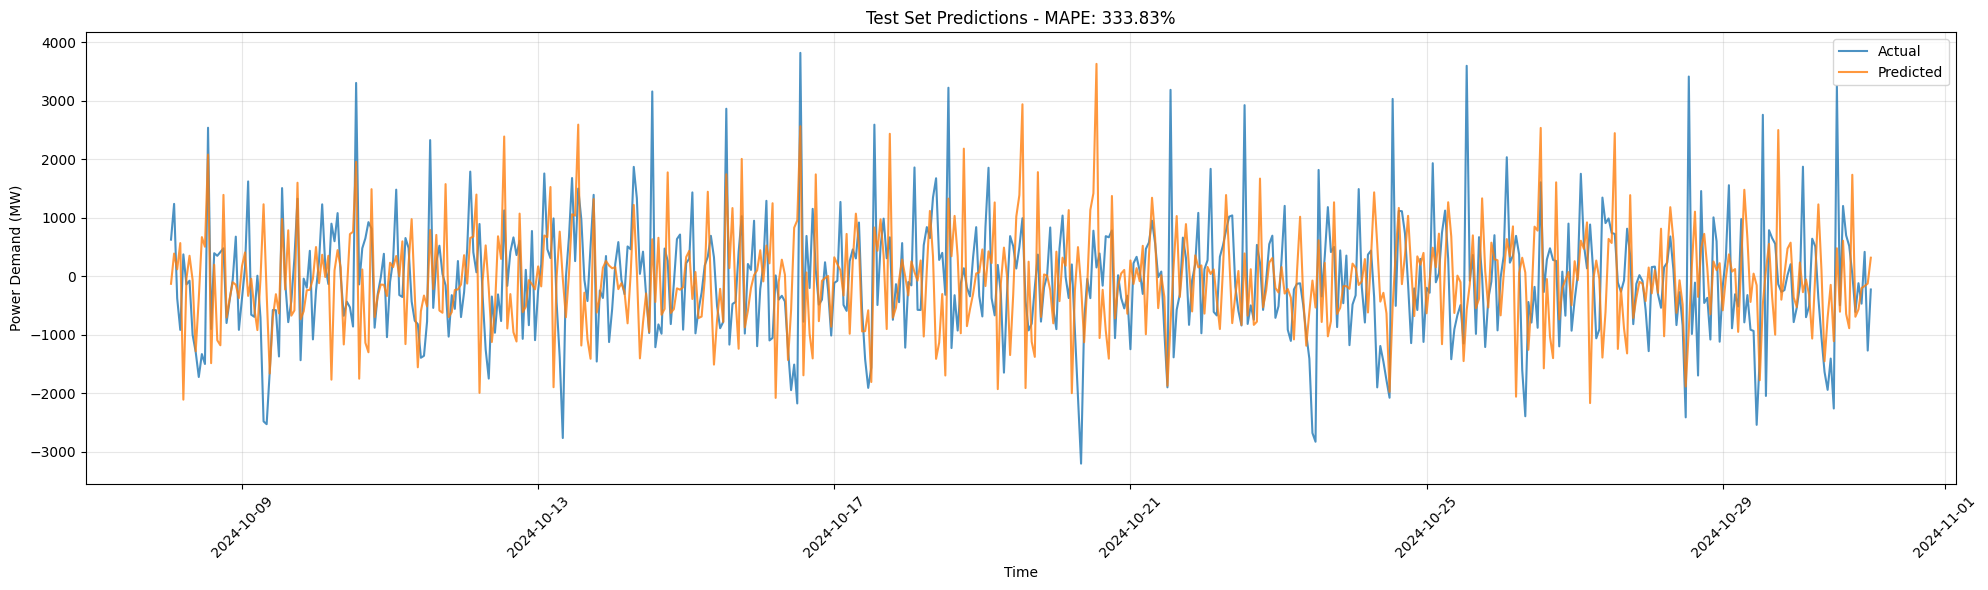

✅ Timeseries plot displayed


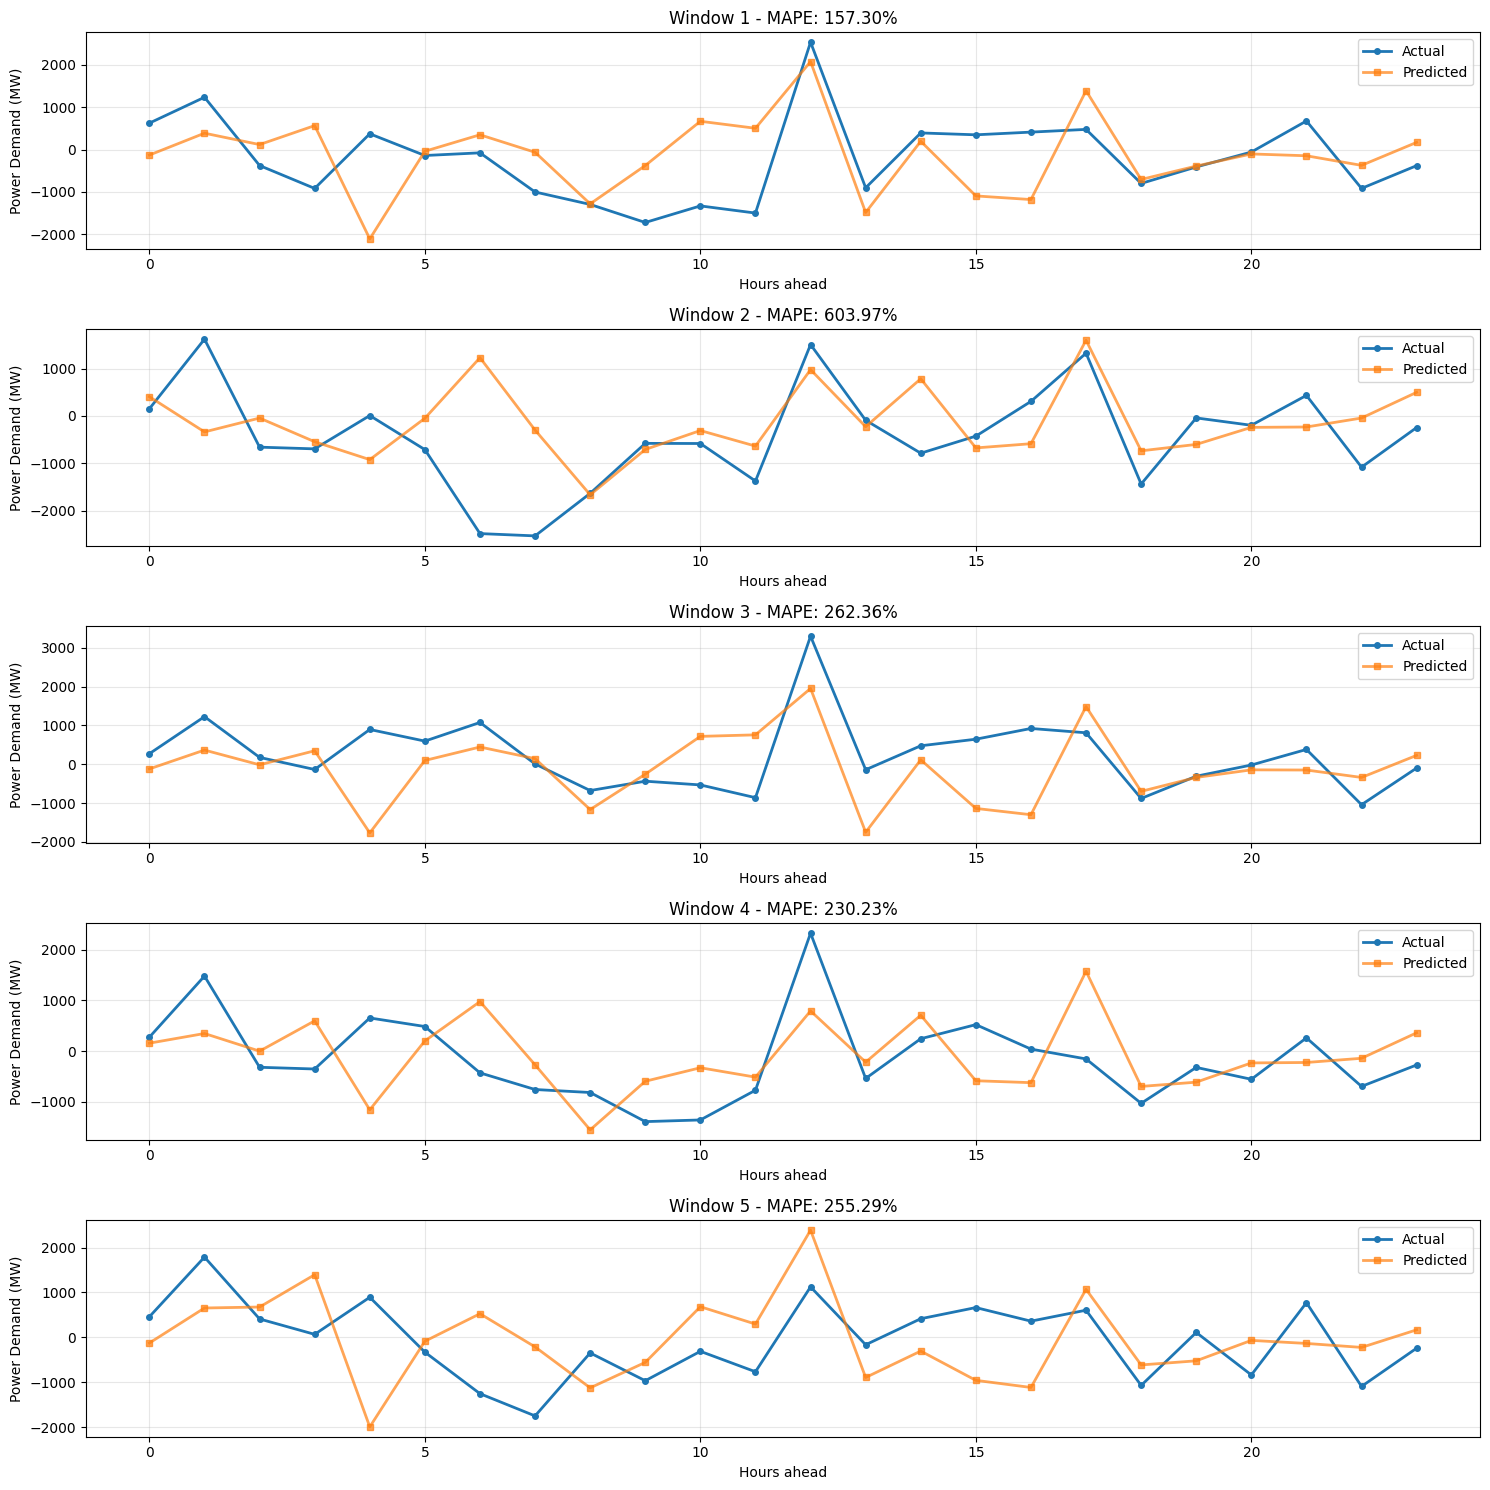

✅ Displayed 5 windows


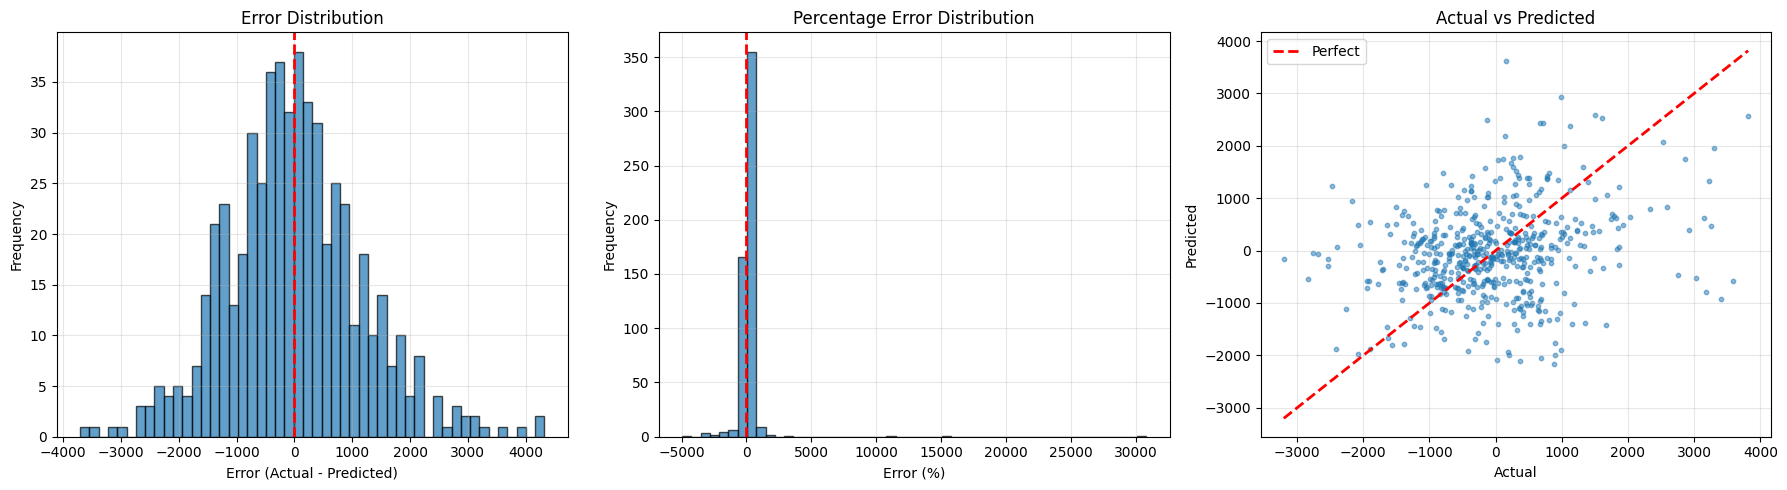

✅ Error analysis displayed


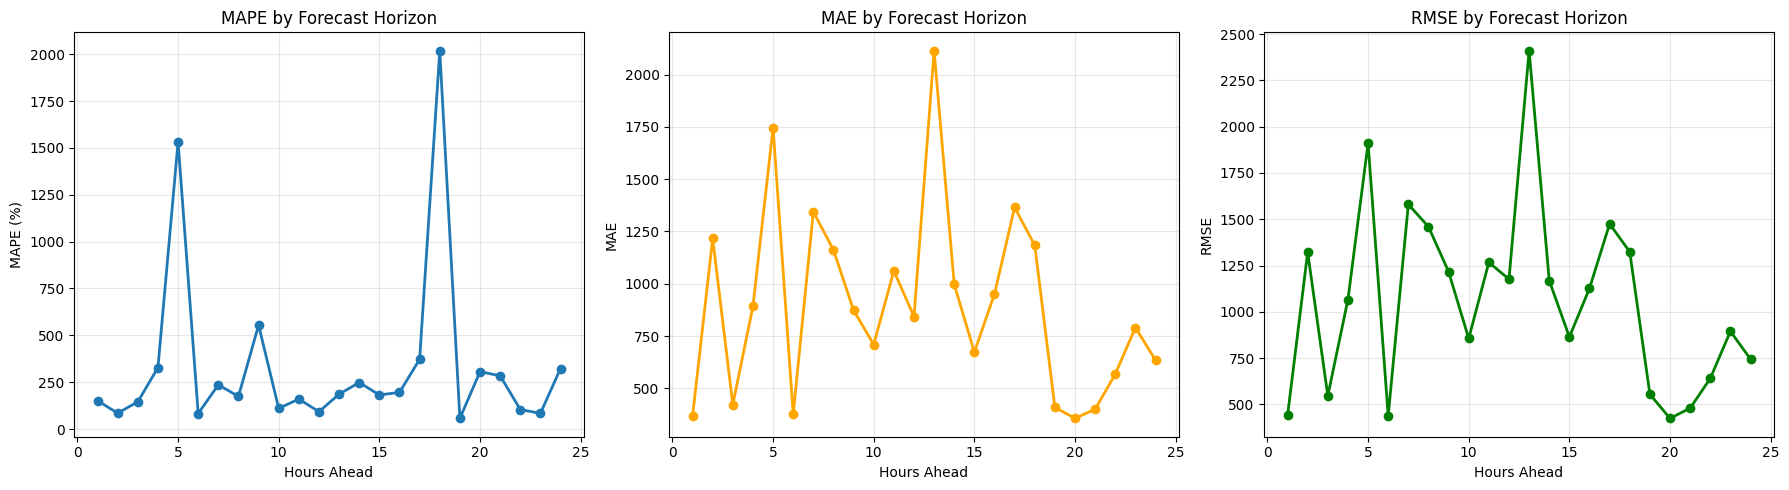

✅ Horizon performance displayed

PER-WINDOW ANALYSIS
Window  1: MAPE=157.30%, MAE= 839.47, RMSE=1082.05
Window  2: MAPE=603.97%, MAE= 794.32, RMSE=1145.77
Window  3: MAPE=262.36%, MAE= 804.04, RMSE=1069.20
Window  4: MAPE=230.23%, MAE= 740.40, RMSE= 884.06
Window  5: MAPE=255.29%, MAE= 971.17, RMSE=1133.94
Window  6: MAPE=282.93%, MAE= 976.28, RMSE=1264.13
Window  7: MAPE=273.88%, MAE= 756.49, RMSE= 979.62
Window  8: MAPE=163.22%, MAE= 807.54, RMSE= 992.01
Window  9: MAPE=835.42%, MAE=1025.94, RMSE=1338.84
Window 10: MAPE=148.13%, MAE= 719.47, RMSE= 884.62
Window 11: MAPE=262.37%, MAE=1112.38, RMSE=1287.51
Window 12: MAPE=231.10%, MAE=1032.28, RMSE=1234.39
Window 13: MAPE=373.76%, MAE=1129.56, RMSE=1475.03
Window 14: MAPE=302.72%, MAE= 734.53, RMSE=1104.12
Window 15: MAPE=119.52%, MAE= 677.32, RMSE= 943.91
Window 16: MAPE=150.44%, MAE= 870.42, RMSE=1106.30
Window 17: MAPE=157.63%, MAE= 991.22, RMSE=1277.76
Window 18: MAPE=1586.11%, MAE= 910.56, RMSE=1257.54
Window 19: MAPE=205.16%, MAE

,timestamp,actual,predicted,error,error_pct
0,2024-10-08 01:00:00,624.995846,-129.248581,754.244427,120.679910
1,2024-10-08 02:00:00,1235.585727,387.008057,848.577671,68.678170
2,2024-10-08 03:00:00,-376.833015,118.232895,-495.065910,131.375408
3,2024-10-08 04:00:00,-917.311879,565.972900,-1483.284780,161.699070
4,2024-10-08 05:00:00,372.896259,-2108.762695,2481.658954,665.509212
5,2024-10-08 06:00:00,-140.040573,-39.464111,-100.576462,71.819516
6,2024-10-08 07:00:00,-76.835209,349.403076,-426.238285,554.743444
7,2024-10-08 08:00:00,-1001.369160,-63.788963,-937.580197,93.629825
8,2024-10-08 09:00:00,-1295.086934,-1281.963135,-13.123800,1.013353
9,2024-10-08 10:00:00,-1721.420808,-376.684906,-1344.735902,78.117791


In [192]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # 한글 폰트 이슈 방지


# ============================================================================
# TEST PREDICTION (Jupyter Notebook용)
# ============================================================================

def predict_test_set(tuner, test_x, test_y, stride=24, verbose=True):
    """
    학습된 tuner 객체로 test 데이터 예측
    
    Args:
        tuner: 학습 완료된 Seq2SeqTuner 객체
        test_x: Test features DataFrame
        test_y: Test target Series
        stride: Window stride (24 = non-overlapping)
        verbose: 진행상황 출력
        
    Returns:
        results: Dict with predictions, actuals, timestamps, metrics
    """
    if verbose:
        print("=" * 80)
        print("TEST SET PREDICTION")
        print("=" * 80)
        print(f"\nTest samples: {len(test_x)}")
        print(f"Window size: {tuner.window_size}h")
        print(f"Horizon: {tuner.horizon}h")
        print(f"Stride: {stride}h")
    
    # Load best model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 같은 노트북에 정의된 클래스 사용
    model = MultivarSeq2SeqLSTM(
        input_size=test_x.shape[1],
        hidden_size=tuner.best_params['hidden_size'],
        num_layers=tuner.best_params['num_layers'],
        dropout=tuner.best_params['dropout'],
        output_size=tuner.horizon,
        output_dim=1,
        bidirectional=tuner.best_params['bidirectional'],
        use_attention=tuner.best_params['use_attention']
    )
    model.load_state_dict(tuner.best_model_state)
    model.to(device)
    model.eval()
    
    scaler_x = tuner.best_scaler_x
    scaler_y = tuner.best_scaler_y
    
    # Create windows
    X_test, y_test = tuner.create_sliding_windows(test_x, test_y, stride=stride)
    
    if verbose:
        print(f"\nTest windows: {len(X_test)}")
        print("Predicting...")
    
    # Predict
    all_predictions = []
    all_actuals = []
    all_timestamps = []
    
    for i in range(len(X_test)):
        # Scale
        X_window = X_test[i]  # (168, features)
        
        # Reshape for scaler
        N, W, F = 1, X_window.shape[0], X_window.shape[1]
        X_scaled = scaler_x.transform(X_window.reshape(-1, F)).reshape(N, W, F).squeeze(0)
        
        X_tensor = torch.FloatTensor(X_scaled).unsqueeze(0).to(device)  # (1, 168, features)
        
        # Predict
        with torch.no_grad():
            y_pred_scaled = model(X_tensor)  # (1, 24, 1)
            y_pred_scaled = y_pred_scaled.cpu().numpy().reshape(1, -1)  # (1, 24)
        
        # Inverse scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
        
        # Get timestamps
        start_idx = i * stride
        timestamps = test_x.index[start_idx+tuner.window_size:start_idx+tuner.window_size+tuner.horizon]
        
        # Store
        all_predictions.append(y_pred)
        all_actuals.append(y_test[i])
        all_timestamps.append(timestamps)
        
        if verbose and (i + 1) % 5 == 0:
            print(f"  {i+1}/{len(X_test)} windows...", flush=True)
    
    # Flatten
    predictions_flat = np.concatenate(all_predictions)
    actuals_flat = np.concatenate(all_actuals)
    timestamps_flat = np.concatenate(all_timestamps)
    
    # Calculate metrics
    metrics = calculate_metrics(actuals_flat, predictions_flat)
    
    if verbose:
        print_metrics(metrics)
    
    return {
        'predictions': predictions_flat,
        'actuals': actuals_flat,
        'timestamps': timestamps_flat,
        'predictions_by_window': np.array(all_predictions),
        'actuals_by_window': np.array(all_actuals),
        'metrics': metrics
    }


def calculate_metrics(actuals, predictions):
    """평가 메트릭 계산"""
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # R²
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'mape': mape,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }


def print_metrics(metrics):
    """메트릭 출력"""
    print("\n" + "=" * 80)
    print("TEST RESULTS")
    print("=" * 80)
    print(f"MAPE:  {metrics['mape']:8.2f}%")
    print(f"MAE:   {metrics['mae']:8.2f}")
    print(f"RMSE:  {metrics['rmse']:8.2f}")
    print(f"R²:    {metrics['r2']:8.4f}")
    print("=" * 80)


def plot_results(results, n_windows=5):
    """
    예측 결과 시각화 (Jupyter에서 바로 표시)
    
    Args:
        results: predict_test_set 결과
        n_windows: 표시할 window 개수
    """
    predictions_by_window = results['predictions_by_window']
    actuals_by_window = results['actuals_by_window']
    
    n_to_plot = min(n_windows, len(predictions_by_window))
    fig, axes = plt.subplots(n_to_plot, 1, figsize=(15, 3*n_to_plot))
    if n_to_plot == 1:
        axes = [axes]
    
    for i in range(n_to_plot):
        ax = axes[i]
        hours = np.arange(len(actuals_by_window[i]))
        
        ax.plot(hours, actuals_by_window[i], 'o-', label='Actual', linewidth=2, markersize=4)
        ax.plot(hours, predictions_by_window[i], 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.7)
        
        window_mape = mean_absolute_percentage_error(actuals_by_window[i], predictions_by_window[i]) * 100
        
        ax.set_xlabel('Hours ahead')
        ax.set_ylabel('Power Demand (MW)')
        ax.set_title(f'Window {i+1} - MAPE: {window_mape:.2f}%')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"✅ Displayed {n_to_plot} windows")


def plot_timeseries(results):
    """시계열 전체 플롯 (Jupyter에서 바로 표시)"""
    fig, ax = plt.subplots(figsize=(20, 6))
    
    timestamps = results['timestamps']
    actuals = results['actuals']
    predictions = results['predictions']
    
    ax.plot(timestamps, actuals, label='Actual', linewidth=1.5, alpha=0.8)
    ax.plot(timestamps, predictions, label='Predicted', linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Power Demand (MW)')
    ax.set_title(f"Test Set Predictions - MAPE: {results['metrics']['mape']:.2f}%")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("✅ Timeseries plot displayed")


def plot_error_analysis(results):
    """오차 분석 플롯"""
    errors = results['actuals'] - results['predictions']
    error_pct = (errors / results['actuals']) * 100
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Error histogram
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Error (Actual - Predicted)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Error Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Error percentage histogram
    axes[1].hist(error_pct, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Error (%)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Percentage Error Distribution')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Scatter plot
    axes[2].scatter(results['actuals'], results['predictions'], alpha=0.5, s=10)
    min_val = min(results['actuals'].min(), results['predictions'].min())
    max_val = max(results['actuals'].max(), results['predictions'].max())
    axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    axes[2].set_xlabel('Actual')
    axes[2].set_ylabel('Predicted')
    axes[2].set_title('Actual vs Predicted')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("✅ Error analysis displayed")


def plot_horizon_performance(results, horizon=24):
    """Horizon별 성능 분석"""
    predictions_by_window = results['predictions_by_window']
    actuals_by_window = results['actuals_by_window']
    
    horizon_mape = []
    horizon_mae = []
    horizon_rmse = []
    
    for h in range(horizon):
        preds_h = predictions_by_window[:, h]
        actuals_h = actuals_by_window[:, h]
        
        mape_h = mean_absolute_percentage_error(actuals_h, preds_h) * 100
        mae_h = mean_absolute_error(actuals_h, preds_h)
        rmse_h = np.sqrt(mean_squared_error(actuals_h, preds_h))
        
        horizon_mape.append(mape_h)
        horizon_mae.append(mae_h)
        horizon_rmse.append(rmse_h)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    hours = np.arange(1, horizon + 1)
    
    # MAPE by horizon
    axes[0].plot(hours, horizon_mape, 'o-', linewidth=2)
    axes[0].set_xlabel('Hours Ahead')
    axes[0].set_ylabel('MAPE (%)')
    axes[0].set_title('MAPE by Forecast Horizon')
    axes[0].grid(True, alpha=0.3)
    
    # MAE by horizon
    axes[1].plot(hours, horizon_mae, 'o-', linewidth=2, color='orange')
    axes[1].set_xlabel('Hours Ahead')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('MAE by Forecast Horizon')
    axes[1].grid(True, alpha=0.3)
    
    # RMSE by horizon
    axes[2].plot(hours, horizon_rmse, 'o-', linewidth=2, color='green')
    axes[2].set_xlabel('Hours Ahead')
    axes[2].set_ylabel('RMSE')
    axes[2].set_title('RMSE by Forecast Horizon')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("✅ Horizon performance displayed")


def save_results(results, csv_path='test_predictions.csv'):
    """결과를 CSV로 저장"""
    results_df = pd.DataFrame({
        'timestamp': results['timestamps'],
        'actual': results['actuals'],
        'predicted': results['predictions'],
        'error': results['actuals'] - results['predictions'],
        'error_pct': ((results['actuals'] - results['predictions']) / results['actuals']) * 100
    })
    results_df.to_csv(csv_path, index=False)
    print(f"✅ Results saved: {csv_path}")
    return results_df


def analyze_per_window(results):
    """Window별 상세 분석"""
    print("\n" + "=" * 80)
    print("PER-WINDOW ANALYSIS")
    print("=" * 80)
    
    predictions_by_window = results['predictions_by_window']
    actuals_by_window = results['actuals_by_window']
    
    for i, (pred, actual) in enumerate(zip(predictions_by_window, actuals_by_window)):
        mape = mean_absolute_percentage_error(actual, pred) * 100
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        
        print(f"Window {i+1:2d}: MAPE={mape:6.2f}%, MAE={mae:7.2f}, RMSE={rmse:7.2f}")
    
    # 평균
    avg_mape = np.mean([mean_absolute_percentage_error(a, p) * 100 
                        for a, p in zip(actuals_by_window, predictions_by_window)])
    print("-" * 80)
    print(f"Average:   MAPE={avg_mape:6.2f}%")
    print("=" * 80)


# 1. Test 예측
results = predict_test_set(
    tuner=tuner,
    test_x=test_x,
    test_y=test_y,
    stride=24,
    verbose=True
)

# 2. 전체 시각화
plot_timeseries(results)

# 3. Window별 예측 비교
plot_results(results, n_windows=5)

# 4. 오차 분석
plot_error_analysis(results)

# 5. Horizon별 성능
plot_horizon_performance(results, horizon=24)

# 6. Window별 상세 분석
analyze_per_window(results)

# 7. 결과 저장
results_df = save_results(results, 'test_predictions.csv')

# 8. 결과 확인
print(f"\\nFinal Test MAPE: {results['metrics']['mape']:.2f}%")
print(f"Final Test RMSE: {results['metrics']['rmse']:.2f}")
print(f"Final Test R²:   {results['metrics']['r2']:.4f}")

# 9. DataFrame 확인
display(results_df.head(50))

In [193]:
nonlinearity = results["predictions"]

In [194]:
test

,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies,trend,detrend,seasonality,t,Fourier_Seasonality,Fourier_Residual
일시,,,,,,,,,,,,,,,,,
2024-10-01 01:00:00,87.182716,18.463730,56153.0,Armed Forces Day,1,0,0,0,1,0,1,64969.719689,-8816.719689,-6495.104410,50401,-6495.104410,-2321.615280
2024-10-01 02:00:00,87.995767,18.115979,54703.0,Armed Forces Day,1,0,0,0,1,0,1,64969.792526,-10266.792526,-8571.064228,50402,-8571.064228,-1695.728298
2024-10-01 03:00:00,89.210229,17.873748,53762.0,Armed Forces Day,1,0,0,0,1,0,1,64969.865362,-11207.865362,-9673.314895,50403,-9673.314895,-1534.550467
2024-10-01 04:00:00,89.362434,17.679797,53654.0,Armed Forces Day,1,0,0,0,1,0,1,64969.938198,-11315.938198,-9285.405373,50404,-9285.405373,-2030.532825
2024-10-01 05:00:00,89.824868,17.562205,54447.0,Armed Forces Day,1,0,0,0,1,0,1,64970.011035,-10523.011035,-7286.481847,50405,-7286.481847,-3236.529188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,75.547619,15.667637,67551.0,non-event,1,0,0,0,1,0,0,65023.495091,2527.504909,4766.217907,51139,4766.217907,-2238.712997
2024-10-31 20:00:00,79.587125,14.787954,65341.0,non-event,1,0,0,0,1,0,0,65023.567987,317.432013,3110.168587,51140,3110.168587,-2792.736574
2024-10-31 21:00:00,82.265079,14.053263,63341.0,non-event,1,0,0,0,1,0,0,65023.640884,-1682.640884,1307.044315,51141,1307.044315,-2989.685199


In [ ]:
# 추세 + 다중계절성 + 비선형성 (AR 모형 제거됨)
test_final = test["trend"][-len(nonlinearity):].values + test["Fourier_Seasonality"][-len(nonlinearity):].values + nonlinearity

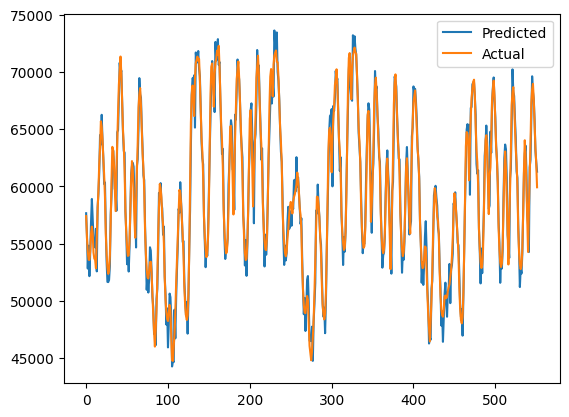

MAPE: 1.67%
MAE: 981.36
RMSE: 1312.06
R²: 0.9615
MSE: 1721495.03


In [202]:
plt.plot(test_final, label="Predicted")
plt.plot(test["power demand(MW)"][-len(nonlinearity):].values, label="Actual")
plt.legend()
plt.show()

# 해당 지표에 대한 평가지표 생성 - 설명력까지
y_true = test["power demand(MW)"][-len(nonlinearity):].values
y_pred = test_final

mape = mean_absolute_percentage_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"MAPE: {mape*100:.2f}%")   # MAPE는 0~1 범위 → 퍼센트로 보려면 ×100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")


In [203]:
MAPE: 1.31%
MAE: 765.79
RMSE: 1017.70
R²: 0.9769
MSE: 1035721.17

SyntaxError: invalid character '²' (U+00B2) (799302086.py, line 4)